In [113]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import chi2
from scipy.linalg import sqrtm
from numpy.linalg import det
import numpy.linalg as LA
import matplotlib.pyplot as plt
import math
from scipy.stats import multivariate_normal
from scipy.stats import invwishart as iw

x_ac_E = []
x_bc_E = []
x_ac_P = []
x_bc_P = []

def generate_covariance(true_mu, dims, df):
    S = np.tril(iw.rvs(df, 1, size=dims**2).reshape(dims, dims))
    cov = np.dot(S, S.T)
    while(np.linalg.det(cov) < 1):
        cov = cov * 2
    mu = np.random.multivariate_normal(true_mu, cov, 1)[0]

    return mu, cov

def oneDvisualize(x, C, ax, label, m=1, linestyle = ''):
    print(x)
    print(C)
    b = np.linspace(x - m*C, x+m*C, 1024)
    p = multivariate_normal.pdf(b, mean=x, cov=C)
    if len(linestyle) == 0:
        ax.plot(b, p, label=label)
    else:
        ax.plot(b, p, label=label, linestyle=linestyle)        


    
def get(dims, df):
    true_mu = np.zeros((dims, ))

    x_ac, C_ac = generate_covariance(true_mu, dims, df)
    x_c, C_c = generate_covariance(true_mu, dims, df)
    x_bc, C_bc = generate_covariance(true_mu, dims, df)
    
    C_bc = np.copy(C_ac)
    
    C_a = LA.inv(LA.inv(C_ac) + LA.inv(C_c))
    C_b = LA.inv(LA.inv(C_bc) + LA.inv(C_c))

    x_a = C_a @ (LA.inv(C_ac) @ x_ac + LA.inv(C_c) @ x_c)
    x_b = C_b @ (LA.inv(C_bc) @ x_bc + LA.inv(C_c) @ x_c)

    C_fus = LA.inv(LA.inv(C_a) + LA.inv(C_b) - LA.inv(C_c))

    return x_a.reshape(1, dims), x_b.reshape(1, dims), C_a, C_b, C_fus
index = 0

In [114]:
C_a_opt = np.linspace(0.01, 1, 30)
def get_predef(index):
    x_a = np.array([[1]])
    x_b = np.array([[-1]])
    C_a = np.array([[C_a_opt[index]]])
    C_b = np.array([[1]])
    C_fus = np.array([[1]])
    index += 1
    return x_a, x_b, C_a, C_b, C_fus

def plot_ellipse(covariance, ax, label_t="", linestyle='', alpha_val=0.25, color_def='red', center = [0, 0]):
    if covariance.shape[0] == 2:
        x_el = np.array([np.sin(np.linspace(0, 2*math.pi, num=63)), np.cos(np.linspace(0, 2*math.pi, num=63))])
        C = np.linalg.cholesky(covariance)
        y_el = np.dot(C, x_el)
        if len(linestyle) > 0:
            if len(label_t) > 0:
                ax.plot(y_el[0] + center[0], y_el[1] + center[1], label=label_t, alpha=alpha_val, color=color_def, linestyle=linestyle)
            else:
                ax.plot(y_el[0] + center[0], y_el[1] + center[1], alpha=alpha_val, color=color_def, linestyle=linestyle)            
        else:
            if len(label_t) > 0:
                ax.plot(y_el[0] + center[0], y_el[1] + center[1], label=label_t, alpha=alpha_val, color=color_def)
            else:
                ax.plot(y_el[0] + center[0], y_el[1] + center[1], alpha=alpha_val, color=color_def)            

def mutual_covariance(cov_a, cov_b):
    D_a, S_a = np.linalg.eigh(cov_a)
    D_a_sqrt = sqrtm(np.diag(D_a))
    D_a_sqrt_inv = inv(D_a_sqrt)
    M = np.dot(np.dot(np.dot(np.dot(D_a_sqrt_inv, inv(S_a)), cov_b), S_a), D_a_sqrt_inv)    # eqn. 10 in Sijs et al.
    D_b, S_b = np.linalg.eigh(M)
    D_gamma = np.diag(np.clip(D_b, a_min=1.0, a_max=None))   # eqn. 11b in Sijs et al.
    return np.dot(np.dot(np.dot(np.dot(np.dot(np.dot(S_a, D_a_sqrt), S_b), D_gamma), inv(S_b)), D_a_sqrt), inv(S_a))  # eqn. 11a in Sijs et al

In [115]:
dims = 1
if dims == 2:
    x_a, x_b, C_a, C_b, C_fus = get(2, 6)
else:
    x_a, x_b, C_a, C_b, C_fus = get_predef(index)
    index += 1
    
x_a = x_a.reshape(1, dims)
x_b = x_b.reshape(1, dims)

def get_critical_value(dimensions, alpha):
    return chi2.ppf((1 - alpha), df=dimensions)



def inv(mat):
    if dims > 1:
        return np.linalg.inv(mat)
    else:
        return 1/mat


In [116]:
eta = get_critical_value(dims, 0.01)
print(eta)

def objective2(S):
    return -(S[0]*S[3])

def objective1(S):
    return -S[0]

def constraint1(S):
    S = S.reshape(dims, dims).T
    A = inv(C_a) - S@S.T
    return np.linalg.eig(A)[0][0]
def constraint2(S):
    S = S.reshape(dims, dims).T
    A = inv(C_a) - S@S.T
    return np.linalg.eig(A)[0][1]
def constraint3(S):
    S = S.reshape(dims, dims).T
    A = inv(C_b) - S@S.T
    return np.linalg.eig(A)[0][0]
def constraint4(S):
    S = S.reshape(dims, dims).T
    A = inv(C_b) - S@S.T
    return np.linalg.eig(A)[0][1]
    
def psuedoinv(A):
    A[np.where(A<=1e-5)] = 1e-5
    
def relu(v):
    return np.log1p(1 + np.exp(v))
        
def pinv(A):
    RELU = np.vectorize(relu)
    tmp_eig, tmp_egv = LA.eig(A)
    M_inv = tmp_egv @ np.diag(1/RELU(tmp_eig)) @ tmp_egv.T
    M = tmp_egv @ np.diag(RELU(tmp_eig)) @ tmp_egv.T
    return M, M_inv

def prob_constraint(S):
    S = S.reshape(dims, dims).T
    C_c_inv = S@S.T

#     tmp = inv(C_a) - C_c_inv
#     tmp_eig, tmp_egv = LA.eig(tmp)
#     C_ac = tmp_egv @ np.diag(1/RELU(tmp_eig)) @ tmp_egv.T
#     C_ac_inv = tmp_egv @ np.diag(RELU(tmp_eig)) @ tmp_egv.T
    if dims == 2:
        C_ac_inv, C_ac = pinv(inv(C_a) - C_c_inv)
        C_bc_inv, C_bc = pinv(inv(C_b) - C_c_inv)
    
        _, C_abc_inv_inv = pinv(C_ac_inv + C_bc_inv)
        _, C_abc_inv = pinv(C_ac + C_bc)
    elif dims == 1:
        C_ac = inv(inv(C_a) - C_c_inv)
        C_ac_inv = inv(C_ac)
        C_bc = inv(inv(C_b) - C_c_inv)
        C_bc_inv = inv(C_bc)
        
        C_abc_inv_inv = inv(C_ac_inv + C_bc_inv)
        C_abc_inv = inv(C_ac + C_bc)

    
#     tmp = inv(C_b) - C_c_inv
#     tmp_eig, tmp_egv = LA.eig(tmp)
#     C_bc = tmp_egv @ np.diag(1/RELU(tmp_eig)) @ tmp_egv.T
#     C_bc_inv = tmp_egv @ np.diag(RELU(tmp_eig)) @ tmp_egv.T
        
#     C_ac = inv(inv(C_a) - C_c_inv)
#     C_bc = inv(inv(C_b) - C_c_inv)
    x_c = (C_abc_inv_inv @ (C_ac_inv @ x_a.T + C_bc_inv @ x_b.T)).T
    x_ac = (C_ac @ (inv(C_a) @ x_a.T - C_c_inv @ x_c.T)).T
    x_bc =(C_bc @ (inv(C_b) @ x_b.T - C_c_inv @ x_c.T)).T
    f = ((x_ac - x_bc) @ C_abc_inv @ (x_ac - x_bc).T)[0][0]
#     print(f)
    return eta - f

def constraint5(S):
    return S[2]



6.6348966010212145


In [117]:
if dims == 2:
    con1 = {'type': 'ineq', 'fun': constraint1}
    con2 = {'type': 'ineq', 'fun': constraint2}
    con3 = {'type': 'ineq', 'fun': constraint3}
    con4 = {'type': 'ineq', 'fun': constraint4}
    con5 = {'type': 'eq', 'fun': prob_constraint}
    con6 = {'type': 'eq', 'fun': constraint5}
    cons = [con1, con2, con3, con4, con5, con6]
if dims == 1:
    con1 = {'type': 'ineq', 'fun': constraint1}
    con3 = {'type': 'ineq', 'fun': constraint3}
    con5 = {'type': 'ineq', 'fun': prob_constraint}
    cons = [con1, con3, con5]

In [118]:
if dims == 1:
    S_0 = 0.99*(np.linalg.cholesky(inv(mutual_covariance(C_a, C_b))).T).reshape(dims**2, )
else:
    S_0 = (np.linalg.cholesky(inv(mutual_covariance(C_a, C_b))).T).reshape(dims**2, )
    
prob_constraint(S_0)

-194.25061215316356

In [119]:
if dims == 2:
    print('Before optimization, we have...')
    print ('objective is',objective2(S_0))
    print ('constraint1 is ',constraint1(S_0))
    print ('constraint2 is ',constraint2(S_0))
    print ('constraint3 is ',constraint3(S_0))
    print ('constraint4 is ',constraint4(S_0))
    print ('constraint5 is ',constraint5(S_0))
    print ('prob_constraint is ',prob_constraint(S_0))


In [122]:
if dims == 2:
    sol = minimize(objective2, S_0, method='trust-constr', constraints=cons)
if dims == 1:
    sol = minimize(objective1, S_0, method='SLSQP', constraints=cons)
# sol = minimize(objective, S_0, method='SLSQP', constraints=cons)


[[0.]]


In [102]:
print(sol)

     fun: -0.6352751656041445
     jac: array([-1.])
 message: 'Optimization terminated successfully'
    nfev: 26
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([0.63527517])


In [121]:
S = sol.x.reshape(dims,dims)
print(prob_constraint(sol.x))
print(eta)
def get_x_c(C_c):
    def mutual_mean(mean_a, cov_a, mean_b, cov_b, cov_m):
        dims = mean_a.shape[0]
        cov_m_inv = inv(cov_m)
        cov_a_inv = inv(cov_a)
        cov_b_inv = inv(cov_b)
        H = cov_a_inv + cov_b_inv - np.multiply(2, cov_m_inv)
        if det(H) == 0:
            eta = 0
        else:
            eig_H, _ = np.linalg.eigh(H)
            smallest_nonzero_ev = min(list(filter(lambda x: x != 0, eig_H)))
            eta = 0.0001 * smallest_nonzero_ev
        eta_I = np.multiply(eta, np.identity(dims))
        first_term = inv(cov_a_inv + cov_b_inv - np.multiply(2, cov_m_inv) + np.multiply(2, eta_I))
        second_term = np.dot(cov_b_inv - cov_m_inv + eta_I, mean_a) + np.dot(cov_a_inv - cov_m_inv + eta_I, mean_b)
        return np.dot(first_term, second_term)
    return mutual_mean(x_a, C_a, x_b, C_b, C_c)

def get_C_ac_x_ac(x_c, C_c):
    C_ac = inv(inv(C_a) - inv(C_c))
    x_ac = C_ac @ (inv(C_a) @ x_a - inv(C_c)@x_c)
    return x_ac, C_ac

def get_C_bc_x_bc(x_c, C_c):
    C_bc = inv(inv(C_b) - inv(C_c))
    x_bc = C_bc @ (inv(C_b) @ x_b - inv(C_c)@x_c)
    return x_bc, C_bc


-9.733547301493672e-12
6.6348966010212145
[[0.]]


In [124]:
S = sol.x
S = S.reshape(dims, dims).T

C_c_PC = inv(S.T) @ inv(S)
x_c_PC = get_x_c(C_c_PC)
C_c_EI = mutual_covariance(C_a, C_b) + 0.01
x_c_EI = get_x_c(C_c_EI)
print(C_c_PC)


x_acP, C_acP = get_C_ac_x_ac(x_c_PC, C_c_PC)
x_bcP, C_bcP = get_C_bc_x_bc(x_c_PC, C_c_PC)
x_ac_P.append(x_acP[0][0])
x_bc_P.append(x_bcP[0][0])



x_acE, C_acE = get_C_ac_x_ac(x_c_EI, C_c_EI)
x_bcE, C_bcE = get_C_bc_x_bc(x_c_EI, C_c_EI)
x_ac_E.append(x_acE[0][0])
x_bc_E.append(x_bcE[0][0])


# if dims == 1:
#     plt.cla()
#     plt.clf()
#     ax = plt.axes()
#     x_c_PC = get_x_c(C_c_PC)

#     oneDvisualize(x_c_PC[0][0], C_c_PC[0][0], ax, "Common Distribution", m =2)
#     oneDvisualize(x_ac[0][0], C_ac[0][0], ax, "Independent A Distribution", m=4)
#     oneDvisualize(x_bc[0][0], C_bc[0][0], ax, "Independent B Distribution", m=2)

#     ax.legend()
#     plt.show()
    
#     x_c_EI = get_x_c(C_c_EI)
#     plt.cla()
#     plt.clf()
#     ax = plt.axes()
#     x_ac, C_ac = get_C_ac_x_ac(x_c_EI, C_c_EI)
#     x_bc, C_bc = get_C_bc_x_bc(x_c_EI, C_c_EI)
#     oneDvisualize(x_c_EI[0][0], C_c_EI[0][0], ax, "Common Distribution", m=15)
#     oneDvisualize(x_ac[0][0], C_ac[0][0], ax, "Independent A Distribution", m=17)
#     oneDvisualize(x_bc[0][0], C_bc[0][0], ax, "Independent B Distribution", m=0.05)
#     ax.legend()
#     plt.show()
    


[[2.47785703]]


In [93]:
print_debug = True
print(C_a)
print(C_b)
if print_debug:
    print ('objective is',objective2(sol.x))
    print ('constraint1 is ',constraint1(sol.x))
    print ('constraint2 is ',constraint2(sol.x))
    print ('constraint3 is ',constraint3(sol.x))
    print ('constraint4 is ',constraint4(sol.x))
    print ('constraint5 is ',constraint5(sol.x))
    print ('prob_constraint is ',prob_constraint(sol.x))

    ax = plt.axes()
    plot_ellipse(C_c_PC, ax, alpha_val=1, linestyle='dashed', label_t="PC Common")

    plot_ellipse(mutual_covariance(C_a, C_b), ax, alpha_val=1, color_def='orange', linestyle='dashed', label_t="EI Common")
    ax.legend()
    plt.show()
    plt.cla()
    plt.clf()

    print(S)

[[0.01]]
[[1]]


IndexError: index 3 is out of bounds for axis 0 with size 1

No handles with labels found to put in legend.


OURS:4.715702999858553
EI:4.999999999999998
TRUE:1.0


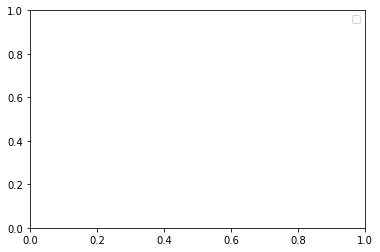

In [37]:
ax = plt.axes()
fus_PC = inv(inv(C_a) + inv(C_b) - inv(C_c_PC))
fus_EI = inv(inv(C_a) + inv(C_b) - inv(mutual_covariance(C_a, C_b)))
# plot_ellipse(C_a, ax)
# plot_ellipse(C_b, ax)
plot_ellipse(fus_PC, ax, color_def="green", alpha_val=1, label_t="PC Fusion")
plot_ellipse(fus_EI, ax, color_def="blue", alpha_val=1, label_t="EI Fusion")
plot_ellipse(C_fus, ax, alpha_val=1, label_t="True Fusion")
print("OURS:" + str(LA.det(fus_PC)))
print("EI:" + str(LA.det(fus_EI)))
print("TRUE:" + str(LA.det(C_fus)))
plt.legend()
plt.show()

In [38]:
print(fus_PC)
print(fus_EI)

[[4.715703]]
[[5.]]
